# Classification of ag plastics across California

Sentinel-2 classification of agricultural plastic use in California based on Harvard students' capstone project and Yuanyuan's internship project

Notebook authored by Annie Taylor, July 2024

Some key changes from previous analyses:
* Using validated training datasets (edited, added precise dates)
* Using different cloud-masking algorithm
* Using updated index equations
* Random stratified sample within polygons instead of sampling every point

### Set up ee api

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime, timedelta
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas
import altair as alt

In [2]:
# ee.Authenticate(auth_mode='localhost')
ee.Initialize(project='ee-annalisertaylor')

### Load data

In [35]:
# Training data - local
# Import the csvs with lat/longs as dfs (could all be one csv/df, keeping separate for testing)
train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/"
santamaria = pd.read_csv(train_path + 'SantaMaria_val_o.csv')
mendocino = pd.read_csv(train_path + 'MendocinoCounty_val_o.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
watsonville = pd.read_csv(train_path + 'Watsonville_val_BM.csv')
watsonville['Type'] = watsonville['Type'].replace('black mulch', 'blackmulch')
oxnard_original = pd.read_csv(train_path + 'YYT_RElabeled_points_date.csv')
oxnard_add = pd.read_csv(train_path + 'Oxnard_additional_val.csv')
oxnard = pd.concat([oxnard_original, oxnard_add], axis=0, ignore_index=True)

# Print out unique 'Type' values for each df to check for typos
print('Checking for typos in the Type column:')
all_dfs = [santamaria, mendocino, watsonville, oxnard]
for df in all_dfs:
    print(df['Type'].unique())

# EE data
assets = 'projects/ee-annalisertaylor/assets/TNC/agplastics/'
# California boundary
ca = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.equals('NAME', 'California'))
# Agricultural areas from CA DWR's crop maps, 2019 to 2022 inclusive (10m raster)
crops = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')

# County boundaries for spatial filtering 
county_bnd = ee.FeatureCollection("TIGER/2016/Counties").filterBounds(ca)
# grab whichever counties you want
ventura = county_bnd.filter(ee.Filter.eq('NAME', 'Ventura'))
mendo = county_bnd.filter(ee.Filter.eq('NAME', 'Mendocino'))
cruz = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Cruz'))
santabarbara = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Barbara'))
# to read all the county options
# county_df = geemap.ee_to_df(county_bnd)
# pd.set_option('display.max_rows', 75)
# county_df['NAME']

# Encode labels - ee classifier requires numeric class labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'blackmulch': 3, 'greenhouse': 4}
# only watsonville has greenhouse points right now, santa maria has a separate (unimported) dataset


Checking for typos in the Type column:
['hoop' 'mulch' 'other']
['other' 'hoop']
['mulch' 'hoop' 'other' 'blackmulch' 'greenhouse']
['hoop' 'mulch' 'other' 'blackmulch']


## 1. Process Sentinel-2 Imagery

### Cloud filter the image collection

In [4]:
startDate = ee.Date.fromYMD(2010, 1, 1) # setting these to be inclusive for now, can change
endDate = ee.Date.fromYMD(2025, 10, 1)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filter(ee.Filter.date(startDate, endDate)) \
    .filter(ee.Filter.bounds(ca)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))
    # .filter(ee.Filter.lt('CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', 92)) #trying another property for clouds covering land
    # this causes an error bc it's not a property until more recently    

#### Cloud filtering with the s2_cloudless collection

In [5]:
# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(ca)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# So I can investigate how this is performing above plastic cover
def addCloudless(img):
    cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
    return img.addBands(cloud_prob.rename('cloud_probability'))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
# cloudless image is saved as a property called 'cloud_mask' in the original image
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

# create the cloud masked image collection
s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

# create an image collection with the cloud probability band, not yet masked
# this is for testing to see what values certain pixels have
s2_cld_test = ee.ImageCollection(s2sr_cloudmask).map(addCloudless)

#### Cloud filtering with the QA band 
Checked this out after seeing problems with the s2_cloudless filter, but apparently this band doesn't contain any info from feb 2022 to feb 2024 so it's not usable

In [6]:
def mask_s2_clouds(image):
   qa = image.select('QA60')
   # Bits 10 and 11 are clouds and cirrus, respectively.
   cloud_bit_mask = 1 << 10
   cirrus_bit_mask = 1 << 11
   # Both flags should be set to zero, indicating clear conditions.
   mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
   return image.updateMask(mask)

s2_qa_cldmsk = s2.map(mask_s2_clouds)

#### Cloud filtering with MSK_CLDPRB band

In [7]:
cloud_threshold = 10

def mask_s2_clouds_cm(image):
   cm = image.select('MSK_CLDPRB')
   isNotCloud = cm.lt(MAX_CLOUD_PROBABILITY)
   return image.updateMask(isNotCloud)

s2_cm_cldmsk = s2.map(mask_s2_clouds_cm)

#### Cloud filtering with the SCL band

In [8]:
# 8 = Clouds Medium Probability
# 9 = Clouds High Probability
# 10 = Cirrus

def mask_s2_clouds_scl(image):
    scl = image.select('SCL')
    isNotCloud = scl.neq(8).And(scl.neq(9).And(scl.neq(10)))
    return image.updateMask(isNotCloud)

s2_scl_cldmsk = s2.map(mask_s2_clouds_scl)

### Vis params

In [9]:
rgbVis = {'min': 400, 'max': 1500, 'bands': ['B4', 'B3', 'B2']}
RPGI_viz = {'min': -0.9, 'max': -0.4, 'palette': ['#4d004b', '#f7fcfd']}
NDTI_viz = {'min': 0.0, 'max': 0.2, 'palette': ['white', 'yellow', 'orange']}
# visualize the classified plastic
plastic_viz = {'palette': ['FF5733', 'F4F31D', '2596be', '#333333'], 'min': 0, 'max': 3}
et_viz = {
  'min': 0,
  'max': 100,
  'palette': [
    '9e6212', 'ac7d1d', 'ba9829', 'c8b434', 'd6cf40', 'bed44b', '9fcb51',
    '80c256', '61b95c', '42b062', '45b677', '49bc8d', '4dc2a2', '51c8b8',
    '55cece', '4db4ba', '459aa7', '3d8094', '356681', '2d4c6e',
  ]
}

### Add VIs

In [10]:
def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B12']).rename('NDTI')) # swir1 and swir2, both 20m, tillage index
    image = image.addBands(image.expression("(100 * b('B2') * (b('B8') - b('B4')))/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('PGI')) # all 10m
    image = image.addBands(image.expression("b('B2')/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('RPGI')) 
    image = image.addBands(image.normalizedDifference(['B11', 'B4']).rename('PMLI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI')) # one band at 20m   
    return image

def adjPGI(image):
    # TODO check if this threshold for NDBI is too high
    # set all bands in the image to 0 where NDVI is higher than 0.73 OR when NDBI is higher than 0.005
    PGI_adj = image.where(image.select('NDVI').gt(0.73), 0)
    PGI_adj = PGI_adj.where(PGI_adj.select('NDBI').gte(0.005), 0)
    # extract the 'PGI' band from that modified image, and add it to the original image with a new name
    image = image.addBands(PGI_adj.select('PGI').rename('PGI_adj'))   
    return image

# not using this right now, keeping it as a useful example for downsampling the NIR band
# will be more precise if we decide to publish any of these data someday
def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image


### Build the collection

In [11]:
# one for each method of cloud filtering, for comparison
# s2_cloudless
processedCollection = s2_cldmsk.map(addVIs)
processedCollection = processedCollection.map(adjPGI)
# scl map
processedCollection_scl = s2_scl_cldmsk.map(addVIs)
processedCollection_scl = processedCollection_scl.map(adjPGI)
# other cloud masks for testing
processedCollection_qa = s2_qa_cldmsk.map(addVIs)
processedCollection_cm = s2_cm_cldmsk.map(addVIs)

# Change the working image collection to the SCL cloud filtered one
processedCollection = processedCollection_scl

# print(processedCollection.size().getInfo())
print(processedCollection.first().bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'NDVI', 'NDMI', 'NDWI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj']


In [13]:
# Select bands to sample from the sentinel-2 images
bands = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI'
]

#### Match training data dates to clear sentinel-2 images

In [22]:
# matching training data to sentinel images, first clear image on or after the point date
date_matching_wats = {
    'points_date': ['2020-09-26', '2021-09-27', '2022-09-11', '2023-04-12', '2019-11-17', '2023-07-09'],
    'image_date': ['2020-09-26', '2021-10-01', '2022-09-16', '2023-04-14', '2019-12-16', '2023-07-28']
}
date_matching_mendo = {
    'points_date': ['2021-06-02'],
    'image_date': ['2021-06-06']
}
date_matching_maria = {
    'points_date': ['2022-08-26', '2023-05-05', '2022-03-10', '2021-02-06'],
    'image_date': ['2022-08-29', '2023-05-11', '2022-03-12', '2021-02-10']
}
date_matching_oxnard = {
    # For 5-6-23, can use 5/11 (has clouds but not on those points specifically) or 4/21,
    # cloud free but 15 days prior
    # for 8-1-2023, clouds far from those specific points, take care if adding more points
    'points_date': ['2023-10-17', '2023-05-06', '2023-11-09', '2019-05-17', '2022-06-13',
                    '2021-07-13', '2022-10-01', '2022-11-01', '2019-10-14', '2020-02-15',
                    '2023-08-01', '2021-02-28'],
    'image_date': ['2023-10-28', '2023-05-11', '2023-11-09', '2019-05-17', '2022-06-15',
                   '2021-07-15', '2022-10-03', '2022-11-02', '2019-10-24', '2020-02-16',
                   '2023-08-01', '2021-03-02']
}
# Convert combined dictionary to dataframe
dates_wats = pd.DataFrame.from_dict(date_matching_wats)
dates_mendo = pd.DataFrame.from_dict(date_matching_mendo)
dates_maria = pd.DataFrame.from_dict(date_matching_maria)
dates_oxnard = pd.DataFrame.from_dict(date_matching_oxnard)
# print(dates_wats, '\n', dates_mendo, '\n', dates_maria, '\n', dates_oxnard)

# combine dfs vertically
date_matching = pd.concat([dates_wats, dates_mendo, dates_maria, dates_oxnard], axis=0, ignore_index=True)
print(date_matching.sort_values(by='points_date'))
# checking that no two points (from diff areas) have the same date

# These are the dates I'm not including right now, bc have fewer points
# Total number of labeled data for 2023-05-07 in Oxnard: 32
# Total number of labeled data for 2019-08-19 in Oxnard: 15
# Total number of labeled data for 2023-05-11 in Oxnard: 17
# Total number of labeled data for 2019-04-01 in Oxnard: 14
# Total number of labeled data for 2022-09-21 in Oxnard: 8

co = santabarbara # ventura, mendo, cruz, santabarbara

# option to import points from csv to show them on the map
# watsonville_points = "N:/OCEANS_Program/projects/Plastics/Agricultural_Plastics/Validated Training Data/Watsonville_val.csv"
# oxnard_points = "N:/OCEANS_Program/projects/Plastics/Agricultural_Plastics/Validated Training Data/YYT_RElabeled_points_date.csv"

date = '2023-06-15'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
oneday_original = s2.filterDate(date, nextday).median()

m = geemap.Map()
m.addLayer(oneday_original, rgbVis, 'original image')
m.addLayer(oneday, rgbVis, 'cloud filtered')
# m.add_points_from_xy(oxnard_points, x="Longitude", y="Latitude")
m.centerObject(co, 10)
# m

   points_date  image_date
14  2019-05-17  2019-05-17
19  2019-10-14  2019-10-24
4   2019-11-17  2019-12-16
20  2020-02-15  2020-02-16
0   2020-09-26  2020-09-26
10  2021-02-06  2021-02-10
22  2021-02-28  2021-03-02
6   2021-06-02  2021-06-06
16  2021-07-13  2021-07-15
1   2021-09-27  2021-10-01
9   2022-03-10  2022-03-12
15  2022-06-13  2022-06-15
7   2022-08-26  2022-08-29
2   2022-09-11  2022-09-16
17  2022-10-01  2022-10-03
18  2022-11-01  2022-11-02
3   2023-04-12  2023-04-14
8   2023-05-05  2023-05-11
12  2023-05-06  2023-05-11
5   2023-07-09  2023-07-28
21  2023-08-01  2023-08-01
11  2023-10-17  2023-10-28
13  2023-11-09  2023-11-09


Map(center=[34.537412985075754, -120.0300786339353], controls=(WidgetControl(options=['position', 'transparent…

#### Investigate cloud filtering issues

In [ ]:
# processedCollection = final collection with VIs added
# processedCollection2 = final collection with VIs added, using QA60 band for cloud filtering
# s2_cldmsk = cloud filtered version
# s2_qa_cldmsk = cloud filtered version using QA60 band
# s2_cm_cldmsk = cloud filtered version using MSK_CLDPRB band
# s2_cld_test = s2 with s2_cloudless data joined, not yet filtered
# s2 = original collection, filtered by date/ca/image cloudiness lt 92

# co = santabarbara # ventura, mendo, cruz, santabarbara
# images_original = processedCollection.filterBounds(co)
# # test_s2 = s2.filterBounds(co)
# images_cloudless = s2_cld_test.filterBounds(co) # get the original image with s2_cloudless probability added
# images_cm = processedCollection_cm.filterBounds(co)
# images_scl = processedCollection_scl.filterBounds(co)

# start = '2020-09-26' # sf cloudy image = '2022-01-01' 
# end = '2022-03-30'

# original = images_original.filterDate(start, end).first()
# original_cloudless = images_cloudless.filterDate(start, end).first()
# cm = images_cm.filterDate(start, end).first()
# scl = images_scl.filterDate(start, end).first()

# m = geemap.Map()
# m.addLayer(original, rgbVis, 'cloud filtered')
# m.addLayer(cm, rgbVis, 'cloud filtered CLDPRB')
# m.addLayer(scl, rgbVis, 'cloud filtered SCL')
# m.addLayer(original_cloudless, rgbVis, 'original image')
# m.centerObject(co, 10)
# m

### Evapotranspiration data

In [29]:
et = ee.ImageCollection('OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0').filterBounds(ca).select('et_ensemble_mad')

# https://developers.google.com/earth-engine/datasets/catalog/OpenET_ENSEMBLE_CONUS_GRIDMET_MONTHLY_v2_0#bands
# Using the ensemble value of ET = 'et_ensemble_mad'

# The ET data only goes through the end of 2023, which is okay with our current training data
# the function will error if we try to sample in 2024 (probably an 'image has no bands' error)

date = ee.Date('2022-07-17')
date = ee.Date(date.format('yyyy-MM-01'))

data = et.filterDate(date, date.advance(1, 'month'))
# display(data)

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.addLayer(data, et_viz, 'Ensemble ET')
# m

## 2. Sample each feature collection to build training dataset
This method uses image matching to ensure there are no cloudy pixels in the training data

Skip to 2b for faster running code if you haven't made changes to imagery / sampling methods

In [16]:
def sample_dates(df):
    df['class'] = df['Type'].map(class_mapping)
    # Format dates to YYYY-MM-DD
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
    # Drop greenhouse, drop points from before 2018-05-09
    df = df[df["Type"]!="greenhouse"]
    df = df[df['Date'] > '2018-05-09'] # TODO write out how many points get filtered
    # Filter for only dates that have a matched sampling image
    df = df.loc[df['Date'].isin(date_matching['points_date'])]

    dates = df['Date'].unique()

    all_area_data = []

    # Iterate through all of the dates in the df
    for date in dates:
        # Get df rows for that date
        df_date = df[df["Date"]==date]
        location = df_date['Location'].iloc[0] # this only works if there's one location per date
        fc_date = geemap.df_to_ee(df_date, latitude='Latitude', longitude='Longitude')
        # Get image date from the date_matching df
        image_date = date_matching.loc[date_matching['points_date'] == date, 'image_date'].iloc[0]
        # Filter images to only that one corresponding sampling date
        image_nextdate = ee.Date(image_date).advance(1, 'day').format('YYYY-MM-dd')
        sample_image = processedCollection.filterDate(image_date, image_nextdate).median()
        # Sample that image to the fc, keeping ‘class’ property
        data = sample_image.select(bands).sampleRegions(
            collection=fc_date,
            properties=['class', 'Latitude', 'Longitude'],
            scale=10, #Reduces points within 10m of each other
            geometries=True
        )

        # Also sample the monthly ET (30m scale, from landsat and other weather data)
        et_date = ee.Date(ee.Date(image_date).format('yyyy-MM-01')) #convert to first of month for ET data
        et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
        data = et_img.sampleRegions(
            collection=data,
            scale=30, #I believe 30m scale reduces points within 30m of each other
            geometries=True
        )
        # Add point date, sampled image date, and location as a property to each feature in the feature collection
        data = data.map(lambda feature: feature.set({
            'date': date,
            'image_date': image_date,
            'location': location
            }))

        # Append to list of fcs for each date
        all_area_data.append(data)

    # Flatten into one fc for the dataset
    area_fc = ee.FeatureCollection(all_area_data).flatten()
    return area_fc

In [30]:
test = sample_dates(oxnard)
test_df = geemap.ee_to_df(test)
display('after sampling', test_df['class'].value_counts())
display('before sampling', oxnard['Type'].value_counts())

# make a df with manually entered points
# but you would also have to add to date_matching for any new image dates
# data_points = [
#     ['Oxnard', '8/1/2023', 'mulch', -119.257339, 34.260933]
# ]
# other_points = pd.DataFrame(data_points, columns=['Location', 'Date', 'Type', 'Longitude', 'Latitude'])


class
2    1008
1     272
0     105
Name: count, dtype: int64

Type
other    1072
mulch     323
hoop      105
Name: count, dtype: int64

###### This is where kirk and I left off 9/4/24

In [18]:
mendo_training = sample_dates(mendocino)
watsonville_training = sample_dates(watsonville)
santamaria_training = sample_dates(santamaria)
oxnard_training = sample_dates(oxnard)

# Combine all data - list of feature collections
all_data = []
all_data.append(mendo_training)
all_data.append(watsonville_training)
all_data.append(santamaria_training)
all_data.append(oxnard_training)

# generate a random number column for training/validation split
data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)

In [ ]:
# save the fc as an asset to drastically speed up later anaylsis
# have to delete this asset first, can't overwrite it

# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data_matched_ET_BM_o'
# task = ee.batch.Export.table.toAsset(
#     collection=data,
#     description='Export training data to asset',
#     assetId=asset_id
# )
# task.start()

## 2b Import fc instead of building it

In [37]:
# import the fc back
asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data_matched_ET_BM_o'
data = ee.FeatureCollection(asset_id)

### 2c violin plots

In [38]:
data_df = geemap.ee_to_df(data)

In [41]:



# Create the violin plot
violin_plot = alt.Chart(data_df).mark_violin().encode(
    x='class:N',
    y='ET:Q',
    color='class:N'
).properties(
    width=400,
    height=300
).interactive()

# Display the plot
violin_plot

ModuleNotFoundError: No module named 'altair'

## 3. Split training and validation data

In [48]:
# Process data (1): Train test split
# print(f"Total number of labeled data:", data.size().getInfo())
split = 0.7
training = data.filter(ee.Filter.lt('random', split))
validation = data.filter(ee.Filter.gte('random', split))
# print(f"Number of training points: {training.size().getInfo()}")
# print(f"Number of validation points: {validation.size().getInfo()}")

#### Training data stats

In [49]:
# convert to dfs for easier stats
# training_df = geemap.ee_to_df(training)
# validation_df = geemap.ee_to_df(validation)

# print(f"Number of training points: {training_df.shape[0]}")
# print(f"Number of validation points: {validation_df.shape[0]}")

# Check number of data in each county
# print("Number of training points:", training_df['county'].value_counts())
# print("Number of validation points:", validation_df['county'].value_counts())

#### Address spatial autocorrelation
- Remove points within 30 meters of each other between the training and validation datasets
- DOES NOT ADDRESS SPATIAL AUTOCORRELATION W/IN THESE DATASETS and also the fact that many of these points are from different dates :/ 

In [50]:
# Process data (2): Address autocorrelation correction
# TODO how are we addressing spatial autocorrelation within each dataset?
# right now this is simply removing any training data points within 30m of a validation point
distFilter = ee.Filter.withinDistance(
    distance=30,
    leftField='.geo',
    rightField='.geo',
    maxError=10
)
join = ee.Join.inverted()
training = join.apply(training, validation, distFilter)
# print(f"Number of training points after removing autocorrelation: {training.size().getInfo()}")

In [51]:
# convert to dfs for easier stats again
training_df = geemap.ee_to_df(training)
# Check number of training data in each region again
display("Number of training points:", training_df['location'].value_counts())
# training_df.head(5)

'Number of training points:'

location
Watsonville    784
Oxnard         682
Santa Maria    612
Mendocino      120
Name: count, dtype: int64

In [52]:
# print("Number of training points of each class:", training_df['class'].value_counts())
for class_name, class_id in class_mapping.items():
   filtered_df = training_df[training_df['class'] == class_id]
   print(f"Number of points labeled {class_name}: {filtered_df.shape[0]}")

Number of points labeled hoop: 524
Number of points labeled mulch: 490
Number of points labeled other: 1141
Number of points labeled blackmulch: 43
Number of points labeled greenhouse: 0


## 4. Train and Evaluate Models

### Random Forest

In [53]:
# bands to train the model on
bands_tr = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI',
    'ET'
]

In [54]:
# Train and test the RF model
# trying it with probability output
trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands_tr)
trainAccuracy_RF = trained_RF.confusionMatrix()

classifications_RF = validation.classify(trained_RF)
validationAccuracy_RF = classifications_RF.errorMatrix('class', 'classification')

# print out accuracy information
print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")
# trained_RF.explain()
# takes about 2 min to run if you have recreated instead of importing the training data, otherwise super fast
# classifications_RF

	Training accuracy:0.9981801637852593
	Validation accuracy:0.9067854694996573


In [59]:
# this gives f score for each class (hoop, mulch, other, blackmulch)
validationAccuracy_RF.fscore().getInfo()

[0.8857589984350548, 0.8871224165341813, 0.925280199252802, 0.8181818181818182]

#### Confusion matrices

Text(0.5, 1.0, 'RF Confusion Matrix (90.68% Accuracy)')

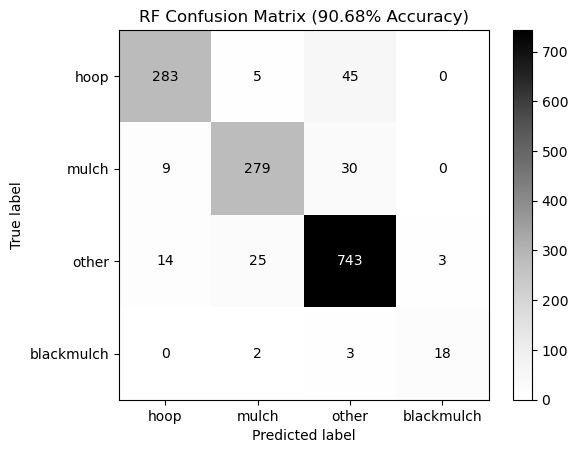

In [55]:
# Plot confusion matrix
display_labels = ['hoop', 'mulch', 'other', 'blackmulch']

cm_RF = np.array(validationAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({validationAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

In [56]:
def plot_each_county_cm(cm_Counties):
  f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

  for i, (county, cm) in enumerate(cm_Counties.items()):
      disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm.getInfo()), display_labels=display_labels)
      disp.plot(ax=axes[i], cmap=plt.cm.Blues)
      disp.ax_.set_title(f"{county} ({cm.accuracy().getInfo():.2%} Accuracy)")
      disp.im_.colorbar.remove()
      disp.ax_.set_xlabel('')
      if i!=0:
          disp.ax_.set_ylabel('')

  f.text(0.4, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.2, hspace=0.1)

  f.colorbar(disp.im_, ax=axes)
  plt.show()

filter_SantaMaria = ee.Filter.stringContains('location', 'Santa Maria')
filter_Mendocino = ee.Filter.stringStartsWith('location', 'Mendocino')
filter_Watsonville = ee.Filter.stringStartsWith('location', 'Watsonville')
filter_Oxnard = ee.Filter.stringStartsWith('location', 'Oxnard')

cm_SantaMaria = classifications_RF.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino = classifications_RF.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville = classifications_RF.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard = classifications_RF.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties = {"Santa Maria": cm_SantaMaria, "Mendocino": cm_Mendocino, "Watsonville": cm_Watsonville, "Oxnard": cm_Oxnard}

In [58]:
# plot_each_county_cm(cm_Counties)

#### Variable Importances

In [60]:
importance = ee.Dictionary(trained_RF.explain().get('importance'))

totalImportance = importance.values().reduce(ee.Reducer.sum())

# helper fn to map over importance values
def percentConvert(key, val):
    return ee.Number(val).divide(totalImportance).multiply(100)
relImportance = importance.map(percentConvert)

importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# convert to pandas df
varImportance = geemap.ee_to_df(importanceFC)

varImportance = varImportance.transpose().rename(columns={0: 'Importance'})
varImportance = varImportance.sort_values(by='Importance', ascending=False)
varImportance

# varImportance.plot(kind='bar')
# plt.show()

,Importance
NDTI,8.310326
B12,6.836701
RPGI,6.716651
ET,6.350658
B6,6.144695
B3,6.091722
NDVI,6.059688
PGI,5.971364
NDBI,5.921265
NDWI,5.880757


#### Reproducible/condensed version
Useful for debugging

In [61]:
# # Reproducible version to test errors
# # import the training data - points labeled with class (0, 1, 2) and containing sampled band info
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data' # needs to be read-only/public
# data = ee.FeatureCollection(asset_id)
# # subset the training data by approx 70% for training (and 30% for validation)
# training = data.filter(ee.Filter.lt('random', 0.7))
# bands = ['B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI']

# trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands)

# importance = ee.Dictionary(trained_RF.explain().get('importance'))

# totalImportance = importance.values().reduce(ee.Reducer.sum())

# # helper fn to map over importance values
# def percentConvert(key, val):
#     return ee.Number(val).divide(totalImportance).multiply(100)
# relImportance = importance.map(percentConvert)

# importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# # convert to pandas df
# varImportance = geemap.ee_to_df(importanceFC)
# varImportance

## 5. Export the model

per [ee docs](https://developers.google.com/earth-engine/apidocs/export-classifier-toasset#colab-python), allows you to build larger models (i.e. more trees, more training samples)

In [62]:
# rf_asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/RF_classifier_matched_ET_BM_o'
# task = ee.batch.Export.classifier.toAsset(
#     classifier=trained_RF,
#     description='classifier_export',
#     assetId=rf_asset_id
# )
# task.start()

## 6. Apply model to imagery

In [63]:
# bring in the saved classifier
# rf_asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/RF_classifier'
rf_asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/RF_classifier_matched_ET_BM_o'
savedClassifier = ee.Classifier.load(rf_asset_id)

#### Get all images from one date, stitch them together, and center the map on that

In [65]:
# for a given date, get images from that date, stitch them together, and center the map on that
# for watsonville ground-truthing, use date = '2021-10-01' and Earth image date 9/30/2021
# https://earth.google.com/web/@36.90600071,-121.7366486,5.73571404a,18340.9275927d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA5LTMwGAE6AwoBMA
# for oxnard ground-truthing, use date = '2022-07-05' and Earth image date 6-30-2022
# https://earth.google.com/web/@34.18104511,-119.12299165,16.77976172a,20704.65705214d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIyLTA2LTMwGAE6AwoBMA
# for santa maria, use date = '2021-03-02' and Earth image date 2-28-2021
# https://earth.google.com/web/@34.92298797,-120.36568793,104.77571464a,20361.02485151d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTAyLTI4GAE6AwoBMA
# for mendocino, use date = '2021-07-01' and Earth image date 6-30-2021 (have to also take off crop mask)
# https://earth.google.com/web/@39.49685652,-123.43778648,742.16477863a,4440.61517426d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA2LTMwGAE6AwoBMA

date = '2021-10-01'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
oneday_original = s2.filterDate(date, nextday).median()

# get ET data for the month of that date
et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')

# add ET band to sentinel-2 image
oneday = oneday.addBands(et_img)

### Classify the image

In [66]:
# make the crop mask
crops = crops.where(crops, 1)

# classify the image
classified = oneday.classify(savedClassifier).updateMask(crops)

# add the classified plastic and composite image to map
m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
m.addLayer(oneday.select('RPGI'), RPGI_viz, 'RPGI', False)
m.addLayer(oneday.select('NDTI'), NDTI_viz, 'NDTI', False)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date)
m.addLayer(classified, plastic_viz, 'Classified Plastic')
m.centerObject(ca, 6)
m

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

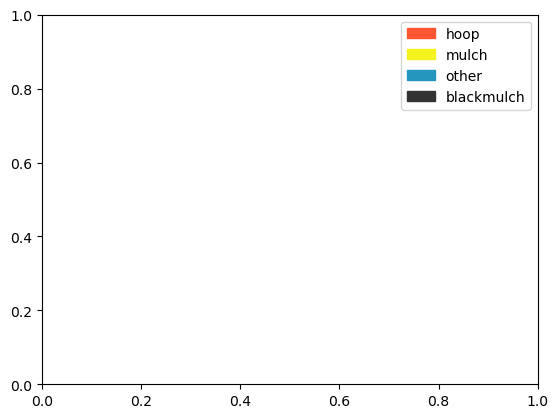

In [67]:
# print out the map legend
colors = ['#FF5733', '#F4F31D', '#2596be', '#333333']
labels = ['hoop', 'mulch', 'other', 'blackmulch']
# colors = ['#FF5733', '#F4F31D', '#2596be']
# labels = ['hoop', 'mulch', 'other']

# Create a legend with the colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(patches, labels)

plt.show()

### Probability classifier

In [30]:
# trained_prob_RF = ee.Classifier.smileRandomForest(50).setOutputMode('PROBABILITY').train(training, 'class', bands_tr)
# trained_prob_RF